# Physical Shapes
Shapes are the basic block of any photonic chip design. We will walk through how to create shapes with GDS Factory.

## Basic Shapes
In GDS Factory we make shapes in Objects called components. In these components we can add shapes and other polygons.

In [36]:
import gdsfactory as gf

PDK = gf.get_generic_pdk()
PDK.activate()

# Our main component
c = gf.Component()

Now we can add polygons to this component. We create polygons by passing in tuples of coordinates into the points argument. When specifying points we need to do this in a circular fashion as seen here.

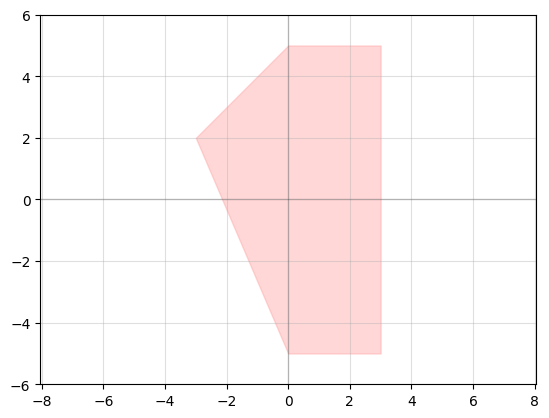

In [37]:
c.add_polygon(points=[(0, 5.0), (3, 5.0), (3.0, -5.0), (0.0, -5.0),(-3.0,2)], layer=1)
c.plot()

To make creating polygons easier we could create a function that that makes the points for us. This function below will help us make shapes with four corners.

In [34]:
def make_four_points(top_length, left_width, bot_length=None, right_width=None):
    # If we only pass the first two arguments this function will return 
    # a list of points that create a polygon with four points. If we put 
    # in the other two arguments we can define the size of any of the sizes 
    # independently.
    
    if bot_length is None: bot_length = top_length
    if right_width is None: right_width = left_width
    if top_length >= bot_length: 
        x_offset = top_length
    else:
        x_offset = bot_length
    # The Polygon has to be made in a circular pattern
    points = [
        (-top_length/2+x_offset/2,left_width/2),
        (top_length/2+x_offset/2,right_width/2),
        (bot_length/2+x_offset/2,-right_width/2),
        (-bot_length/2+x_offset/2,-left_width/2)
    ]
    return points

print(make_four_points(3,10))

[(0.0, 5.0), (3.0, 5.0), (3.0, -5.0), (0.0, -5.0)]


Now say we want to make a tapered polygon. We can use this function like so.

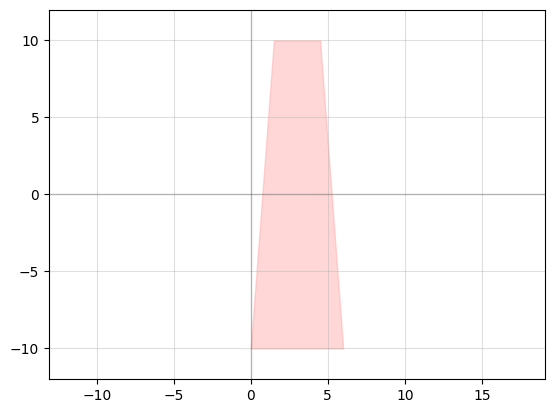

In [35]:
taper_input = 3
taper_output = 6
taper_width = 20

# Create a new component
taper = gf.Component()

# Use our new polygon function
points = make_four_points(top_length=taper_input, left_width=taper_width, bot_length=taper_output)
taper.add_polygon(points=points, layer=1)
taper.plot()